### 링크모음

* 확률분포 메서드(numpy)  
https://datascienceschool.net/view-notebook/e6c0d4ff9f4c403c8587c7d394bc930a/

* curve_fit 을 이용한 model fitting  
https://smlee729.github.io/python/simulation/2015/03/25/2-curve_fitting.html

* curve_fit 설명  
https://sdc-james.gitbook.io/onebook/4.-numpy-and-scipy/4.3-scipy/4.3.2.-optimization


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit
from datetime import datetime

In [4]:
data_folder = '../data/imported/dataset/'
data = pd.read_csv(data_folder + 'Time/Time.csv', index_col=0)
data.index = pd.to_datetime(data.index)

# date - 날짜
# time - 발표시간
# test - 누적 검사 수
# negative - 누적 음성 결과 수
# confirmed - 누적 양성 결과 수 (확진)
# released - 누적 격리 해제 수
# deceased - 누적 사망 수

data.tail()

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-04-16,0,538775,513894,10613,7757,229
2020-04-17,0,546463,521642,10635,7829,230
2020-04-18,0,554834,530631,10653,7937,232
2020-04-19,0,559109,536205,10661,8042,234
2020-04-20,0,563035,540380,10674,8114,236


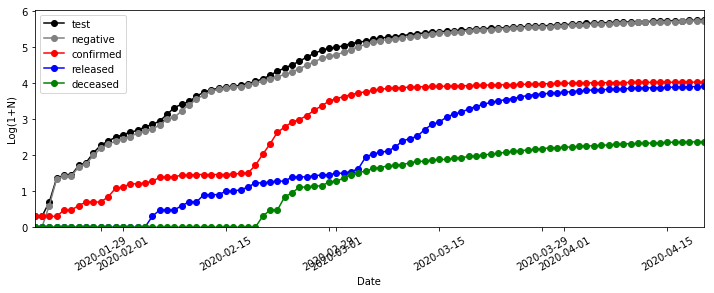

In [5]:
def to_log(data):
    return np.log10(data+1)

plt.figure(figsize=(12, 4))
plt.plot(to_log(data['test']), '-o', label='test', color='k')
plt.plot(to_log(data['negative']), '-o', label='negative', color='gray')
plt.plot(to_log(data['confirmed']), '-o', label='confirmed', color='r')
plt.plot(to_log(data['released']), '-o', label='released', color='b')
plt.plot(to_log(data['deceased']), '-o', label='deceased', color='g')
plt.legend()
plt.ylabel('Log(1+N)')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(data.index[0], data.index[-1])
plt.xticks(rotation=30)
plt.show()

### 2020-02-18 부터 확진자 급증

In [6]:
one_day = pd.DataFrame(data=data.iloc[1:].values - data.iloc[:-1].values, columns = data.columns)
one_day.index = data.index[1:]
one_day.head()

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-01-21,0,0,0,0,0,0
2020-01-22,0,3,3,0,0,0
2020-01-23,0,18,18,0,0,0
2020-01-24,0,5,4,1,0,0
2020-01-25,0,0,0,0,0,0


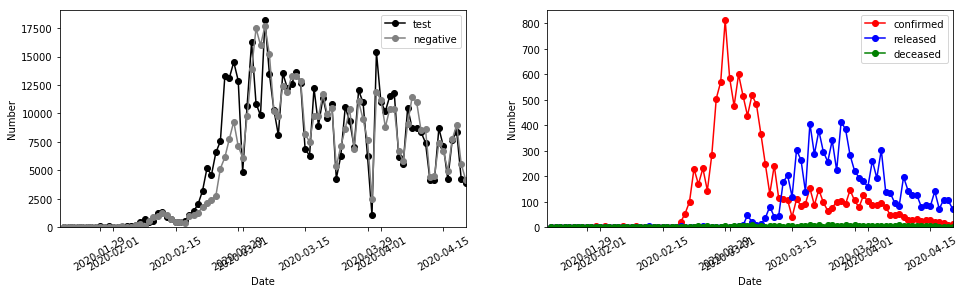

In [8]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(one_day['test'], '-o', label='test', color='k')
plt.plot(one_day['negative'], '-o', label='negative', color='gray')
plt.legend()
plt.ylabel('Number')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(data.index[0], data.index[-1])
plt.xticks(rotation=30)

plt.subplot(122)
plt.plot(one_day['confirmed'], '-o', label='confirmed', color='r')
plt.plot(one_day['released'], '-o', label='released', color='b')
plt.plot(one_day['deceased'], '-o', label='deceased', color='g')
plt.legend()
plt.ylabel('Number')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(data.index[0], data.index[-1])
plt.xticks(rotation=30)

plt.show()

In [9]:
one_day['ratio'] = 100 * one_day['confirmed'] / one_day['test']

## 테스트 당 확진 비율(확진율)

확진자 수와 검사 수로 확진율을 계산합니다.

확진율 = 확진자 수 / 검사 수 X 100

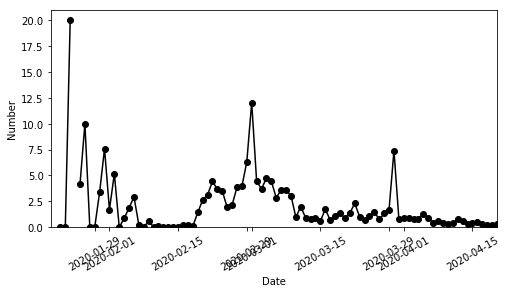

확진율 (%) (확진자 수/검사 수 X 100)
전체	: 2.0393 %
최근 2주	: 1.6817 %


In [12]:
plt.figure(figsize=(8, 4))
plt.plot(one_day['ratio'], '-o', label='test', color='k')
plt.ylabel('Number')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(data.index[0], data.index[-1])
plt.xticks(rotation=30)
plt.show()
print('확진율 (%) (확진자 수/검사 수 X 100)')
print('전체\t: %.4f %%'%(one_day['ratio'].mean()))
print('최근 2주\t: %.4f %%'%(one_day['ratio'].iloc[14:].mean()))

### 순수 확진자 수
날짜별 순수 확진자 수를 아래 식을 통해 계산 합니다.   
순수 확진자 수는 누적 확진자 수에서 격리 해제 수와 사망자 수를 제한 값 입니다.  
순수 확진자 수 = 확진자 수 - 격리 해제 수 - 사망자 수  

In [13]:
data['x'] = data['confirmed'] - data['released'] - data['deceased']

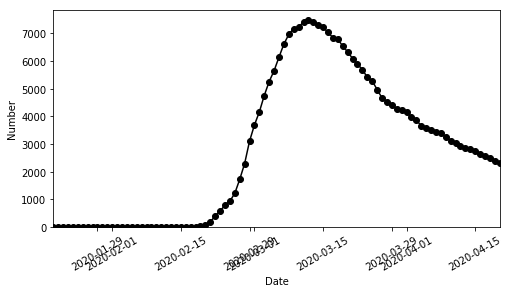

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(data['x'], '-o', label='test', color='k')
plt.ylabel('Number')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(data.index[0], data.index[-1])
plt.xticks(rotation=30)
plt.show()

### 순수 확진자 수 예측

순수 확진자 수의 추세를 알아보기 위해 왜정규분포 (skew normal distribution)을 사용해 curve-fit을 수행했습니다.

In [16]:
def skew_normal(x, m, a, s, n):
    t = (x-m)/s
    output = 2 / s * scipy.stats.norm.pdf(t) * scipy.stats.norm.cdf(a*t)
    return n * output

In [25]:
xdata = list(range(0, len(data)))
## data[x] 는 순수확진자 수
ydata = data['x']

# print(xdata)
# print(ydata)

popt, pcov = curve_fit(skew_normal, xdata, ydata, bounds=([40, 3, 20, 200000], [45, 5, 25, 300000]))

print(popt)
## curve_fit 의 결과값은 2개가 나오는데
## 하나는 최적화된 함수의 파라미터 값들이고
## pcov는 popt의 적용범위이다.

[4.24125409e+01 4.42517757e+00 2.50000000e+01 2.63103733e+05]


Empty DataFrame
Columns: []
Index: [2020-01-20 00:00:00, 2020-01-21 00:00:00, 2020-01-22 00:00:00, 2020-01-23 00:00:00, 2020-01-24 00:00:00, 2020-01-25 00:00:00, 2020-01-26 00:00:00, 2020-01-27 00:00:00, 2020-01-28 00:00:00, 2020-01-29 00:00:00, 2020-01-30 00:00:00, 2020-01-31 00:00:00, 2020-02-01 00:00:00, 2020-02-02 00:00:00, 2020-02-03 00:00:00, 2020-02-04 00:00:00, 2020-02-05 00:00:00, 2020-02-06 00:00:00, 2020-02-07 00:00:00, 2020-02-08 00:00:00, 2020-02-09 00:00:00, 2020-02-10 00:00:00, 2020-02-11 00:00:00, 2020-02-12 00:00:00, 2020-02-13 00:00:00, 2020-02-14 00:00:00, 2020-02-15 00:00:00, 2020-02-16 00:00:00, 2020-02-17 00:00:00, 2020-02-18 00:00:00, 2020-02-19 00:00:00, 2020-02-20 00:00:00, 2020-02-21 00:00:00, 2020-02-22 00:00:00, 2020-02-23 00:00:00, 2020-02-24 00:00:00, 2020-02-25 00:00:00, 2020-02-26 00:00:00, 2020-02-27 00:00:00, 2020-02-28 00:00:00, 2020-02-29 00:00:00, 2020-03-01 00:00:00, 2020-03-02 00:00:00, 2020-03-03 00:00:00, 2020-03-04 00:00:00, 2020-03-05 00:00:00

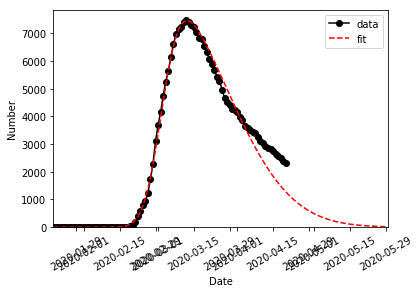

In [26]:
prediction = pd.DataFrame(index=pd.date_range(data.index[0], '2020-5-30'))
print(prediction)
prediction.index.name = 'date'
prediction['data'] = np.NaN
prediction['data'].loc[data['x'].index] = data['x']
prediction['idx'] = list(range(0, len(prediction+1)))
prediction['pred'] = prediction['idx'].apply(lambda x:skew_normal(x, popt[0], popt[1], popt[2], popt[3]))

plt.plot(prediction['data'], '-o', label='data', color='k')
plt.plot(prediction['pred'], '--', label='fit', color='r')
plt.legend()
plt.ylabel('Number')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.xlim(prediction.index[0], prediction.index[-1])
plt.xticks(rotation=30)
plt.show()